# SVM

Guía comprensiva para SVM. y para QSVM.

In [1]:
# Classic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm 

## Hybrid Considerations.

Parte del proceso matemático que sigue el SVM:
|
- Buscar los $\vec{\alpha}$ que minimicen la función L:

$$L = -\sum_{i=0}^{m}\alpha_{i} + \frac{1}{2} \sum_{i=0}^{m} \sum_{j=0}^{m} \alpha_{i} \alpha_{j} f(\vec{x_{i}}) f(\vec{x_{j}}) \vec{x_{i}} \cdot \vec{x_{j}}$$

Donde:
- $\vec{x_i}$ hace referencia a las características del i-ésimo dato punto, feature vector.
- $f(\vec{x_i})$ a su etiqueta correspondiente.

Una vez minimizada la función $L$ a partir de $\vec{\alpha}$ se puede conseguir el hiperplano de clasificación, aquí se vuelve de interés, solo tenemos que cambiar un poco la función introduciendo $\vec{\phi}$ que será la función que mapeará de un plano a otro, así es que introduciremos el kernel.

Tan solo hay que cambiar la función a minimizar:

$$L = -\sum_{i=0}^{m}\alpha_{i} + \frac{1}{2} \sum_{i=0}^{m} \sum_{j=0}^{m} \alpha_{i} \alpha_{j} f(\vec{x_{i}}) f(\vec{x_{j}}) \phi(\vec{x_{i}}) \cdot \phi(\vec{x_{j}})$$

Por tanto, lo que haremos será calcular todos lo productos internos a traves del nuestra función de mapeo, es decir, la matriz de Gramm, esta matriz esta compeusta de productos; calcularemos los productos internos $\phi(\vec{x_{i}}) \cdot \phi(\vec{x_{j}})$

Ejmeplo:

Digamos que tenemos un vector:

- $(\vec{x_{i}})$ = [0.5, 1.3]

 
Debido a esto codificaremos en fase, para ello podemos usar las compuertas $R_x ,  R_y$, sin embargo si quisiera cambiar el espacio en el que están solo tendría que aplicar otras compuertas, como en el ejemplo:


En otras palabras tendremos que:


$$\phi(\vec{x_{i}}) = U(\vec{x_{i}})\ket{00}$$


Para minimizar la función nos interesa el producto interno de $\phi(\vec{x_{i}}) \cdot \phi(\vec{x_{j}})$, por lo que según lo anterior, tendríamos:

______________________
$$ \bra{00}U(\vec{x_{i}})^tU(\vec{x_{j}})\ket{00}$$
______________________

La expresión anterior puede ser contener un número imaginario y podríamos calcular el modulo al cuadrado de la expresión quedarnos con la parte real:

______________________
$$|\bra{00}U(\vec{x_{i}})^tU(\vec{x_{j}})\ket{00}|^2$$
______________________

Para calcular la expresión anterior podemos usar el SWAP TEST, otra opción es construir ese circuito (de esa expresión), y calcular la probabilidad de obtener $\bra{00}$, es equivalente, a obtener el producto interno.

## Matriz de Gram.

Es la matriz que almacena los productos internos de $\phi(\vec{x_{i}}) \cdot \phi(\vec{x_{j}})$. Esta se ve así, para cada producto de los vectores.

$$\begin{pmatrix}\phi(\vec{x_{0}}) \cdot \phi(\vec{x_{0}})&...&...\\&...&...\\&...&...\\&...&...\\&...&\phi(\vec{x_{n}}) \cdot \phi(\vec{x_{m}})\end{pmatrix}$$

Esto es lo que le introducimos como dato al SVM para pueda minimzar la función.


In [2]:
#Quantum dependencies
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import svm
import scipy

ModuleNotFoundError: No module named 'pennylane'

## Load data

- Creamos dataset ficticio y hacemos los split de datos normales.

120


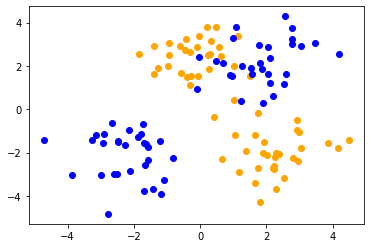

In [ ]:
n_samples = 30 * 4
A = np.array([[np.random.normal(loc=0), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
B = np.array([[np.random.normal(loc=2), np.random.normal(loc=-2)] for i in range(n_samples//4)]) 
C = np.array([[np.random.normal(loc=2), np.random.normal(loc=2)] for i in range(n_samples//4)]) 
D = np.array([[np.random.normal(loc=-2), np.random.normal(loc=-2)] for i in range(n_samples//4)])

feature = np.concatenate([A, B,C,D], axis=0)/4
label = np.concatenate([-np.ones(n_samples // 2), np.ones(n_samples//2)], axis=0)
data = list(zip(feature, label))

np.random.shuffle(data)
print(len(data))
plt.scatter(A[:,0], A[:,1], color = "orange")
plt.scatter(B[:,0], B[:,1], color = "orange")
plt.scatter(C[:,0], C[:,1], color = "blue")
plt.scatter(D[:,0], D[:,1], color = "blue")
plt.show()

In [ ]:
porcentaje_train = 0.5
m = int(porcentaje_train * n_samples)


x_train = np.array([data[i][0] for i in range(m)])
y_train = np.array([data[i][1] for i in range(m)])
x_test = np.array([data[i][0] for i in range(m,n_samples)])
y_test = np.array([data[i][1] for i in range(m,n_samples)])

n = len(x_train[0])


- **Feature Map**: Mapa de caracteristica, función que estamos mapeando. Es la función que podemos crear nuestro propio vector inicial que mapea en ese espacio como queremos.

In [ ]:

## Sección Optimizable -Circuito.
@qml.template
def feature_map(x):
    
    # ZZMap modificado
    for i in range(2):
        qml.Hadamard(wires = i)


    qml.RZ(2*x[0], wires = 0)
    qml.RZ(2*x[1], wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RZ(2*(np.pi - x[0])*(np.pi - x[1]), wires = 1)
    qml.CNOT(wires = [0,1])
    

Aqui podemos construir circuitio: $U^t\vec{x_{i}}U(\vec{x_{j}})$ y aplicarlo sobre el $\ket{00}$

In [ ]:
dev = qml.device("default.qubit", wires = n)      
@qml.qnode(dev)
def circuit(x,y):
    feature_map(y)
    qml.adjoint(feature_map)(x)
    return qml.probs(wires = range(n))



Es la probabilidad de observar el 0, como producto escalar.

In [ ]:
# devuelve el valor final del producto interno
def scalar_product(x,y):
    probs = circuit(x,y)
    return probs[0]

Calcularemos la matriz de productos internos.

In [ ]:
# Esto es básicament elo que se mete en el Kernel
def KernelGramMatrixFull(X1, X2):
    print("Calculando matriz de Gram")
    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            
            x1 = x1.flatten()
            x2 = x2.flatten()
            
            gram_matrix[i, j] = scalar_product(x1,x2)
            
    return gram_matrix


Entrenamos el SVM, usando sklearn para poder aprovecharnos de las funcioens de minimización.

In [ ]:
clf = svm.SVC(kernel="precomputed")
matrix = KernelGramMatrixFull(x_train,x_train)
print("Entrenando...")
clf.fit(matrix, y_train)


Calculando matriz de Gram


C:\Users\alejandro.gl\AppData\Local\Temp\ipykernel_50512\3916297289.py:4: UserWarning: The template decorator is deprecated and will be removed in release v0.20.0
  feature_map(y)
c:\Users\alejandro.gl\Documents\Cerebellum\Quantum Computing\env_q\lib\site-packages\pennylane\transforms\adjoint.py:115: UserWarning: The template decorator is deprecated and will be removed in release v0.20.0
  fn(*args, **kwargs)


Entrenando...


SVC(kernel='precomputed')

Cosntruimos la matriz de Gramm junto los datos de entrenamiento y prueba también.

In [ ]:
#test
print("Comprobando con test...")
sol = clf.predict(KernelGramMatrixFull(x_test,x_train))
success = 0
for i in range(len(y_test)):
    if sol[i] == y_test[i]:
        success += 1
        
print("Precisión del test: ", success/len(sol)*100, "%")


Comprobando con test...
Calculando matriz de Gram


C:\Users\alejandro.gl\AppData\Local\Temp\ipykernel_50512\3916297289.py:4: UserWarning: The template decorator is deprecated and will be removed in release v0.20.0
  feature_map(y)
c:\Users\alejandro.gl\Documents\Cerebellum\Quantum Computing\env_q\lib\site-packages\pennylane\transforms\adjoint.py:115: UserWarning: The template decorator is deprecated and will be removed in release v0.20.0
  fn(*args, **kwargs)


Precisión del test:  81.66666666666667 %


Realizar chunk de compración.

predicción


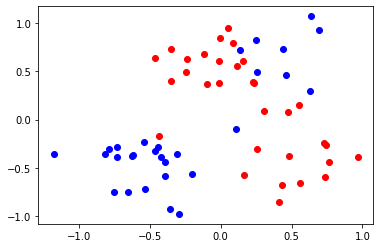

In [ ]:
print("predicción")

for i in range(len(x_test)):
    color ="blue"
    if sol[i] ==-1:
        color="red"
    plt.scatter(x_test[i,0], x_test[i,1], color=color)

plt.show()

real


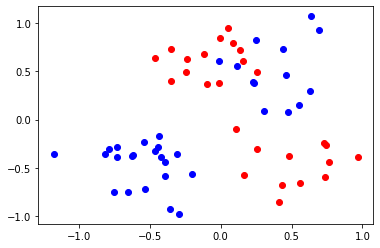

In [ ]:
print("real")

for i in range(len(x_test)):
    color ="blue"
    if y_test[i] ==-1:
        color="red"
    plt.scatter(x_test[i,0], x_test[i,1], color=color)

plt.show()